# Data preparation

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import Cdf
import Pmf


# define global plot parameters
params = {'axes.labelsize' : 12, 'axes.titlesize' : 12,
          'font.size' : 12, 'legend.fontsize' : 12,
          'xtick.labelsize' : 12, 'ytick.labelsize' : 12}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
# helper function to get CDFs for an array of dataframes for a specific column name
def get_cdfs(dfs, col):
    cdfs = []
    for df in dfs:
        cdfs.append(Cdf.MakeCdfFromList(df[col]))
    return cdfs

### Cache Identification based on heuristic (see paper)
Matching source and destination AS numbers indicate that request stayed within ISP network

In [3]:
# connect to database and get data
conn = sqlite3.connect('data/youtube-traceroute.db')

# cache for IPv4 only
v4_caches = pd.read_sql_query('select * \
                               from pair_medians_meta \
                               where src_asn_v4 = dst_asn_v4 and src_asn_v6 != dst_asn_v6', conn)

# cache for IPv6 only
v6_caches = pd.read_sql_query('select * \
                               from pair_medians_meta \
                               where src_asn_v4 != dst_asn_v4 and src_asn_v6 = dst_asn_v6', conn)

# caches for both
both_caches = pd.read_sql_query('select * \
                                 from pair_medians_meta \
                                 where src_asn_v4 = dst_asn_v4 and src_asn_v6 = dst_asn_v6', conn)

# no cache
no_caches = pd.read_sql_query('select * \
                               from pair_medians_meta \
                               where src_asn_v4 != dst_asn_v4 and src_asn_v6 != dst_asn_v6', conn)  

conn.close()

## Putting lists of the four cases together for plotting

- IPv4 cache, no IPv6 cache
- IPv6 cache, no IPv4 cache
- caches for both
- no caches for either

In [4]:
# all lists will represent the four cases above and therefore have length 4
data = [v4_caches, 
        v6_caches, 
        both_caches,
        no_caches]
titles = ['(v4 but no v6 cache)', 
          '(v6 but no v4 cache)',
          '(v4 and v6 caches)',
          '(no ISP caches)']
filenames = ['v4_cache',
             'v6_cache',
             'both_caches',
             'no_cache']

# use helper function to get CDFs for each cases, and each metric
cdfs_ttl = get_cdfs(data, 'm_ttl_delta')
cdfs_rtt = get_cdfs(data, 'm_rtt_delta')

# Plotting

### Put all four cases into shared plots
- one plot for TTL
- one plot for RTT

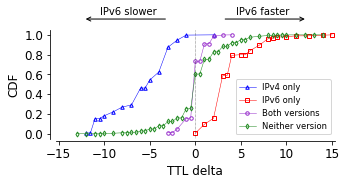

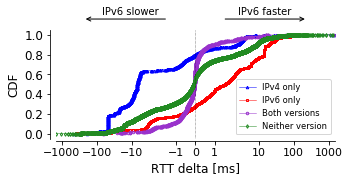

In [5]:
markers = ['^',
           's',
           'o',
           'd']
colors = ['blue',
          'red',
          'darkorchid',
          'forestgreen']
labels = ['IPv4 only',
          'IPv6 only',
          'Both versions',
          'Neither version']


## TTL
ttl_fig, ttl_ax = plt.subplots(figsize = (5, 2))
for i in range(4):
    ttl_ax.plot(cdfs_ttl[i].xs, cdfs_ttl[i].ps, 
                label = '%s' % (labels[i]), 
                marker = markers[i], 
                linewidth = 0.5, 
                markersize = 3.5, 
                fillstyle = 'none', 
                color = colors[i])

# PLOT FORMATTING
ttl_ax.set_xlabel('TTL delta')
ttl_ax.set_ylabel('CDF')
ttl_ax.set_xlim([-15.3, 15.3])
ttl_ax.set_ylim([-0.05, 1.05])
ttl_ax.legend(loc = 'lower right', fontsize = 'small')

yticks = np.arange(0.0, 1.01, 0.2)
ttl_ax.set_yticks(yticks)
ttl_ax.grid(False)
ttl_ax.spines['right'].set_color('none')
ttl_ax.spines['top'].set_color('none')
ttl_ax.yaxis.set_ticks_position('left')
ttl_ax.xaxis.set_ticks_position('bottom')
ttl_ax.spines['bottom'].set_position(('axes', -0.02))
ttl_ax.spines['left'].set_position(('axes', -0.02))


## RTT
rtt_fig, rtt_ax = plt.subplots(figsize = (5, 2))
for i in range(4):
    rtt_ax.plot(cdfs_rtt[i].xs, cdfs_rtt[i].ps,
                label = '%s' % (labels[i]),
                marker = markers[i],
                linewidth = 0.5,
                markersize = 2.5,
                fillstyle = 'none',
                color = colors[i])

# PLOT FORMATTING
# customize axes and grid appearance
rtt_ax.set_xlabel('RTT delta [ms]')
rtt_ax.set_xscale('symlog')
rtt_ax.set_ylabel('CDF')
rtt_ax.set_ylim([-0.05, 1.05])
rtt_ax.set_xlim([-1500, 1500])
rtt_ax.tick_params(axis = 'x', which = 'major', labelsize = 11)
rtt_ax.legend(loc = 'lower right', fontsize = 'small')

rtt_ax.set_yticks(yticks)
rtt_ax.grid(False)
rtt_ax.spines['right'].set_color('none')
rtt_ax.spines['top'].set_color('none')
rtt_ax.yaxis.set_ticks_position('left')
rtt_ax.xaxis.set_ticks_position('bottom')
rtt_ax.spines['bottom'].set_position(('axes', -0.02))
rtt_ax.spines['left'].set_position(('axes', -0.02))

from matplotlib.ticker import ScalarFormatter
rtt_ax.xaxis.set_major_formatter(ScalarFormatter())


# add arrows and text which indicate in which region IPv6 was better/worse than IPv4
ttl_ax.annotate('', xy = (0.4, 1.1), 
                xycoords = 'axes fraction',
                xytext = (0.1, 1.1),
                arrowprops = dict(arrowstyle = "<-"))
ttl_ax.annotate('', xy = (0.9, 1.1),
                xycoords = 'axes fraction',
                xytext = (0.6, 1.1),
                arrowprops = dict(arrowstyle = '->'))
ttl_ax.text(-10.5, 1.2, 'IPv6 slower')
ttl_ax.text(4.5, 1.2, 'IPv6 faster')

rtt_ax.annotate('', xy = (0.4, 1.1),
                xycoords = 'axes fraction',
                xytext = (0.1, 1.1),
                arrowprops = dict(arrowstyle = '<-'))
rtt_ax.annotate('', xy = (0.9, 1.1),
                xycoords = 'axes fraction',
                xytext = (0.6, 1.1),
                arrowprops = dict(arrowstyle = '->'))
rtt_ax.text(-70, 1.2, 'IPv6 slower')
rtt_ax.text(2.5, 1.2, 'IPv6 faster')

# dotted vertical line to separate positive and negative delta region
ttl_ax.axvline(0, linestyle = 'dotted', color = 'black', linewidth = 0.5)
rtt_ax.axvline(0, linestyle = 'dotted', color = 'black', linewidth = 0.5)

# saving and showing plot
ttl_fig.savefig('plots/caches_ttl_comparison.pdf', bbox_inches = 'tight')
rtt_fig.savefig('plots/caches_rtt_comparison.pdf', bbox_inches = 'tight')
plt.show()

## Distributions of median deltas for all cases

In [6]:
# separate TTL CDFs out of list
v4, v6, both, no = cdfs_ttl

In [7]:
print('---- TTL v4 ----')
print('m_ttl_delta; cdf')
print('----------------')
for x, y in zip(v4.xs, v4.ps):
    print('%.2f; %.5f' % (x, y))

print('\n--------------------------------------------------------\n')

print('---- TTL v6 ----')
print('m_ttl_delta; cdf')
print('----------------')
for x, y in zip(v6.xs, v6.ps):
    print('%.2f; %.5f' % (x, y))
    
print('\n--------------------------------------------------------\n')

print('--- TTL both ---')
print('m_ttl_delta; cdf')
print('----------------')
for x, y in zip(both.xs, both.ps):
    print('%.2f; %.5f' % (x, y))
    
print('\n--------------------------------------------------------\n')

print('--- TTL none ---')
print('m_ttl_delta; cdf')
print('----------------')
for x, y in zip(no.xs, no.ps):
    print('%.2f; %.5f' % (x, y))

---- TTL v4 ----
m_ttl_delta; cdf
----------------
-12.00; 0.00695
-11.50; 0.00759
-11.00; 0.15234
-10.50; 0.15360
-10.00; 0.18078
-9.00; 0.22124
-8.00; 0.26991
-7.00; 0.29077
-6.00; 0.46144
-5.50; 0.46207
-5.00; 0.54298
-4.00; 0.62389
-3.00; 0.87484
-2.00; 0.94564
-1.00; 0.99747
2.00; 1.00000

--------------------------------------------------------

---- TTL v6 ----
m_ttl_delta; cdf
----------------
0.00; 0.00445
1.00; 0.09503
2.00; 0.15590
3.00; 0.58797
3.50; 0.58872
4.00; 0.79287
5.00; 0.79955
5.50; 0.80030
6.00; 0.83964
7.00; 0.89384
8.00; 0.96288
8.50; 0.96362
9.00; 0.97773
10.00; 0.98070
11.00; 0.98961
12.50; 0.99035
14.00; 0.99629
15.00; 1.00000

--------------------------------------------------------

--- TTL both ---
m_ttl_delta; cdf
----------------
-3.00; 0.01136
-2.50; 0.01190
-2.00; 0.04545
-1.00; 0.15260
-0.50; 0.15963
0.00; 0.73052
0.50; 0.73268
1.00; 0.90801
1.50; 0.91017
2.00; 0.98485
3.00; 0.99838
4.00; 1.00000

------------------------------------------------------

In [8]:
# separate RTT CDFs out of list
v4, v6, both, no = cdfs_rtt

In [9]:
print('---- RTT v4 ----')
print('m_rtt_delta; cdf')
print('----------------')
for x, y in list(zip(v4.xs, v4.ps))[0::10]:
    print('%.2f; %.5f' % (x, y))

print('\n--------------------------------------------------------\n')

print('---- RTT v6 ----')
print('m_rtt_delta; cdf')
print('----------------')
for x, y in list(zip(v6.xs, v6.ps))[0::10]:
    print('%.2f; %.5f' % (x, y))
    
print('\n--------------------------------------------------------\n')

print('--- RTT both ---')
print('m_rtt_delta; cdf')
print('----------------')
for x, y in list(zip(both.xs, both.ps))[0::10]:
    print('%.2f; %.5f' % (x, y))
    
print('\n--------------------------------------------------------\n')

print('--- RTT none ---')
print('m_rtt_delta; cdf')
print('----------------')
for x, y in list(zip(no.xs, no.ps))[0::100]:
    print('%.2f; %.5f' % (x, y))

---- RTT v4 ----
m_rtt_delta; cdf
----------------
-462.17; 0.00063
-121.74; 0.00695
-111.39; 0.01327
-107.39; 0.01960
-82.70; 0.02592
-51.09; 0.03224
-48.85; 0.03856
-48.77; 0.04488
-48.68; 0.05120
-48.57; 0.05815
-48.52; 0.06511
-48.47; 0.07206
-48.43; 0.07965
-48.39; 0.08597
-48.30; 0.09292
-48.26; 0.09924
-48.22; 0.10556
-48.19; 0.11315
-48.15; 0.11947
-48.09; 0.12705
-48.02; 0.13338
-47.97; 0.13970
-47.92; 0.14602
-47.89; 0.15297
-47.83; 0.15929
-47.72; 0.16561
-47.65; 0.17193
-47.54; 0.17889
-43.15; 0.18521
-34.62; 0.19153
-31.88; 0.19848
-31.54; 0.20480
-30.99; 0.21176
-25.50; 0.21808
-23.59; 0.22440
-23.27; 0.23072
-23.08; 0.23704
-22.80; 0.24336
-22.33; 0.24968
-21.55; 0.25601
-21.14; 0.26233
-18.73; 0.26865
-16.92; 0.27497
-15.02; 0.28129
-14.22; 0.28761
-12.80; 0.29393
-12.32; 0.30025
-11.79; 0.30657
-11.22; 0.31290
-10.90; 0.31922
-10.71; 0.32554
-10.52; 0.33186
-10.31; 0.33881
-10.01; 0.34513
-9.84; 0.35145
-9.55; 0.35777
-9.36; 0.36410
-9.19; 0.37105
-9.05; 0.37737
-8.95;